# Object Detection

- Window sliding (sliding prediction window across the image and making prediction on ht selected part. Windows can have different sizes)
- Selective search (randomly chosing different size windows and selecting one with highrest IOU (`Intersection over Union`))

### Model architectures

## R-CNN

Regional Convolutional Neural Network

Regions with CNN. 

- Takes `input image`
- extracts `region proposals` (using selective search)
- `warped regions` (rescaling extracted images so that they match size expected by pretrained CNN)
- computes CNN features (feature extraction)
- `SVM` (classification), `Regression` (bounging boxes)

R-CNN are slow and need a lot of memory.

##### Fast R-CNN
- Takes `region proposals`
- `region of interest projection`
- `softmax` (classification), `Regression` (bounging boxes)

##### Faster R-CNN
- only convolutions, not Dense layers
- uses `sliding window`
- `softmax` (classification), `Regression` (bounging boxes)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageOps
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from six.moves.urllib.request import urlopen
from six import BytesIO
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
model = hub.load(module_handle)
model.signatures.keys()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x1BA19289190>}))

In [3]:
detector = model.signatures['default']

In [2]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    filename = 'image.ipg'
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    if display:
        plt.imshow(pil_image_rgb)
    return filename

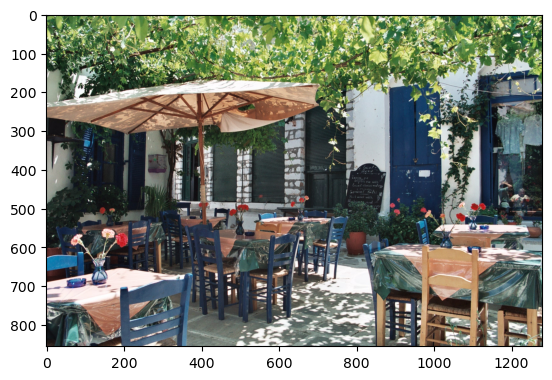

In [3]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [4]:
def draw_bounding_box_on_image(image,ymin,xmin,ymax,xmax,color,display_str_list=()):
    thickness=4
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),(left, top)],width=thickness,fill=color)
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
    
    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
    
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),(left + text_width, text_bottom)],fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),display_str,fill="black")
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil,ymin,xmin,ymax,xmax,color,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [5]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img


def run_detector(detector, path):
    img = load_img(path)
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    result = {key:value.numpy() for key,value in result.items()}
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)

    image_with_boxes = draw_boxes(img.numpy(), result["detection_boxes"],result["detection_class_entities"], result["detection_scores"])
    plt.imshow(image_with_boxes)

In [ ]:
run_detector(detector, './image.ipg')

Found 100 objects.
Inference time:  18.755096912384033


C:\Users\pk764\AppData\Local\Temp\ipykernel_10456\2288392663.py:9: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
C:\Users\pk764\AppData\Local\Temp\ipykernel_10456\2288392663.py:18: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


---

#### Assesment

In [ ]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

In [ ]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

# Compile the Object Detection API protocol buffers and install the necessary packages
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import os
import random
import zipfile
import io
import scipy.misc
import numpy as np
import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
import tensorflow as tf

In [ ]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import colab_utils

In [2]:
def load_image_into_numpy_array(path):
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size

    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,boxes,classes,scores,category_index,figsize=(12, 16),image_name=None):
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(image_np_with_annotations,boxes,classes,scores,category_index,use_normalized_coordinates=True,min_score_thresh=0.8)

    if image_name:
        plt.imsave(image_name, image_np_with_annotations)

    else:
        plt.imshow(image_np_with_annotations)


#### data download

In [ ]:
!wget --no-check-certificate https://storage.googleapis.com/tensorflow-3-public/datasets/training-zombie.zip -O ./training-zombie.zip

local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

In [ ]:
%matplotlib inline
train_image_dir = './training'
train_images_np = []

for i in range(1, 6):
    image_path = os.path.join(train_image_dir+'/training-zombie' + str(i) + '.jpg')
    print(image_path)
    train_images_np.append(load_image_into_numpy_array(image_path))
    
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

In [ ]:
override = False
ref_gt_boxes = [
        np.array([[0.27333333, 0.41500586, 0.74333333, 0.57678781]]),
        np.array([[0.29833333, 0.45955451, 0.75666667, 0.61078546]]),
        np.array([[0.40833333, 0.18288394, 0.945, 0.34818288]]),
        np.array([[0.16166667, 0.61899179, 0.8, 0.91910903]]),
        np.array([[0.28833333, 0.12543962, 0.835, 0.35052755]]),
      ]

if not gt_boxes or override is True:
  gt_boxes = ref_gt_boxes

for gt_box in gt_boxes:
    try:
      assert(gt_box is not None)
    except:
      gt_boxes = ref_gt_boxes

      break

In [ ]:
zombie_class_id = 1
category_index = {zombie_class_id:{'id':zombie_class_id,'name':'zombie'}}
num_classes = 1

#### data preprocessing

In [ ]:
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

#### download the checkpoint containing the pre-trained weights

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

!cp -r ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/ ./models/research/object_detection/test_data/

#### configure the model

In [ ]:
tf.keras.backend.clear_session()
pipeline_config = './models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
configs

model configuration

In [ ]:
model_config = configs['model']
model_config

modify configuration

In [ ]:
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
model_config

build model

In [ ]:
detection_model = model_builder.build(model_config, is_training=True)
print(type(detection_model))

defining checkpoints

In [ ]:
tmp_box_prediction_head = tf.train.Checkpoint(_box_prediction_head = detection_model._box_predictor._box_prediction_head)

tmp_box_predictor_checkpoint = tf.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head = detection_model._box_predictor._box_prediction_head
    )

In [ ]:
tmp_model_checkpoint = tf.train.Checkpoint(
  _box_predictor = tmp_box_predictor_checkpoint,
  _feature_extractor = detection_model._feature_extractor
)

restoring checkpoint

In [ ]:
checkpoint_path = './models/research/object_detection/test_data/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint/ckpt-0'
checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint)
checkpoint.restore(checkpoint_path)

In [ ]:
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1,640,640,3]))
tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)
tmp_detections = detection_model.postprocess(tmp_prediction_dict,tmp_shapes)

print('Weights restored!')

training hyperparameters

In [ ]:
tf.keras.backend.set_learning_phase(True)
batch_size = 5
num_batches = 100
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)

choosing layers to fine-tune

In [ ]:
tmp_list = []
for v in detection_model.trainable_variables:
  if v.name.startswith('WeightSharedConvolutionalBoxPredictor'):
    tmp_list.append(v)
to_fine_tune = tmp_list

model training

In [ ]:
g_images_list = train_image_tensors[0:2]

In [ ]:
g_preprocessed_image = detection_model.preprocess(g_images_list[0])

In [ ]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

prediction

In [ ]:
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

In [ ]:
gt_boxes_list = gt_box_tensors[0:2]
gt_classes_list = gt_classes_one_hot_tensors[0:2]

detection_model.provide_groundtruth(groundtruth_boxes_list=gt_boxes_list,groundtruth_classes_list=gt_classes_list)

loss

In [ ]:
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

#### reseting model

In [ ]:
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

training step

In [ ]:
@tf.function
def train_step_fn(image_list,groundtruth_boxes_list,groundtruth_classes_list,model,optimizer,vars_to_fine_tune):

    with tf.GradientTape() as tape:
        # Preprocess the images
        preprocessed_image_list = []
        true_shape_list = []

        for img in image_list:
            processed_img, true_shape = detection_model.preprocess(img)
            preprocessed_image_list.append(processed_img)
            true_shape_list.append(true_shape)

        preprocessed_image_tensor = None
        true_shape_tensor = None
        preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
        true_shape_tensor = tf.concat(true_shape_list, axis=0)

        # Make a prediction
        prediction_dict = None
        prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

        # Calculate the total loss (sum of both losses)

        detection_model.provide_groundtruth(groundtruth_boxes_list, groundtruth_classes_list)
        total_loss = None
        losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
        localization_loss = losses_dict['Loss/localization_loss']
        classification_loss = losses_dict['Loss/classification_loss']
        total_loss = localization_loss + classification_loss

        # Calculate the gradients
        gradients = None
        gradients = tape.gradient([localization_loss, classification_loss], [detection_model.trainable_variables[0],detection_model.trainable_variables[2]])

        # Optimize the model's selected variables
        optimizer.apply_gradients(zip(gradients, [detection_model.trainable_variables[0],detection_model.trainable_variables[2]]))
        
    return total_loss

training loop

In [ ]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    # Get the ground truth
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]

    # get the images
    image_tensors = [train_image_tensors[key] for key in example_keys]

    # Training step (forward pass + backwards pass)
    total_loss = train_step_fn(image_tensors,gt_boxes_list,gt_classes_list,detection_model,optimizer,to_fine_tune)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)+ ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

inference

In [ ]:
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

!wget --no-check-certificate https://storage.googleapis.com/tensorflow-3-public/datasets/zombie-walk-frames.zip -O zombie-walk-frames.zip

local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

In [ ]:
test_image_dir = './results/'
test_images_np = []

# load images into a numpy array. this will take a few minutes to complete.
for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path), axis=0))

In [ ]:
@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    detections = detection_model.postprocess(prediction_dict,shapes)
    return detections

In [ ]:
label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(test_images_np[i][0],detections['detection_boxes'][0].numpy(),detections['detection_classes'][0].numpy().astype(np.uint32)+ label_id_offset,detections['detection_scores'][0].numpy(),category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [ ]:
print(len(results['boxes']))
print(results['boxes'][0].shape)
print()

# compare with expected bounding boxes
print(np.allclose(results['boxes'][0], [0.28838485, 0.06830047, 0.7213766 , 0.19833465], rtol=0.18))
print(np.allclose(results['boxes'][5], [0.29168868, 0.07529271, 0.72504973, 0.20099735], rtol=0.18))
print(np.allclose(results['boxes'][10], [0.29548776, 0.07994056, 0.7238164 , 0.20778716], rtol=0.18))

In [ ]:
x = np.array(results['scores'])

# percent of frames where a zombie is detected
zombie_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(zombie_detected)

In [ ]:
print('Frame 0')
display(IPyImage('./results/gif_frame_000.jpg'))
print()
print('Frame 5')
display(IPyImage('./results/gif_frame_005.jpg'))
print()
print('Frame 10')
display(IPyImage('./results/gif_frame_010.jpg'))